# Predicción en servidor
Ejemplo de petición de predicción a servidor

In [1]:
PORT = 8000 # If running on container -> 80
API = f'https://u2f5le55w5.execute-api.us-east-2.amazonaws.com/DummyStage/newdata/fromweb'
API_KEY = 'Gq5isfVY25aCcyxYDf1xa3BocEMrCLUk2IcmfXaw'

In [2]:
import base64
import json
from time import strftime, localtime, time
from os import path
from sys import getsizeof


import cv2 as cv
import requests
from requests.exceptions import HTTPError



In [3]:
class Sender:
    def __init__(self, api_endpoint, api_key=None):
        self.API_ENDPOINT = api_endpoint
        self.API_KEY = api_key
        print('Sender API {}'.format(self.API_ENDPOINT))

    def pack_data(self, obs_data):
        """Add data, modify and encode data, to set ready to send"""
        obs_data['frame'] = self.im2json(obs_data['frame'])
        json_data = json.dumps(obs_data)
        print('Package size: {} Kilobyte'.format(getsizeof(json_data) / 1000))
        return json_data

    def send_request(self, frameData):
        """Send general request to server"""
        print('Sending request...')
        json_data = self.pack_data(frameData)
        headers = {"x-api-key": self.API_KEY}

        try:
            url = self.API_ENDPOINT
            print('Wating server response...')
            response = requests.post(url, data=json_data, headers=headers, timeout=6000)  # data-> body in http request
            # If the response was successful, no Exception will be raised
            response.raise_for_status()
        except HTTPError as http_err:
            print('HTTP error occurred: {}'.format(http_err))
            raise HTTPError(http_err)
        except Exception as err:
            print('Other error occurred: {}'.format(err))  # Python 3.6
            raise Exception(err)
        else:
            print('Successfully sent package')
            return response

    def im2json(self, im):
        """Encode image to send"""
        _, imdata = cv.imencode('.JPG', im)
        im_str = base64.b64encode(imdata).decode('ascii')
        return im_str

In [4]:
def send_request(filepath):
    date = strftime("%Y-%m-%d_%H:%M:%S", localtime()) # No cambiar formato de la fecha
    im = cv.imread(filepath)
    payload = {
        'frame': im,
        'user': 'juanca',
    }

    my_sender = Sender(API, API_KEY)
    start = time()
    res = my_sender.send_request(payload)

    if res.status_code == 200:
        print(res.text)
        print(f'Elapsed: {round(time()-start, 3)}s')

In [5]:
# Take photo in Colab
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


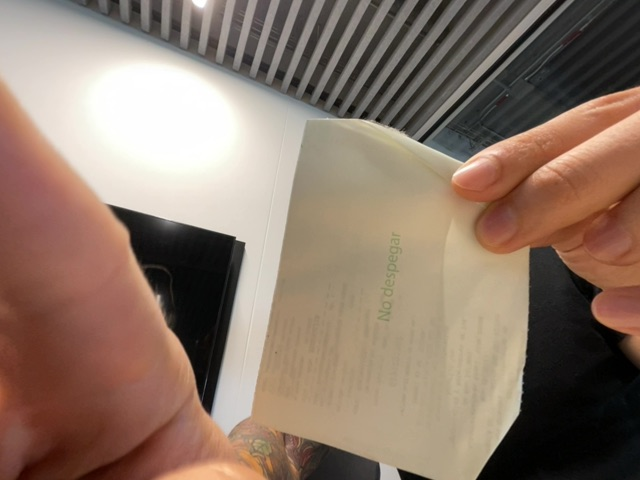

Sender API https://u2f5le55w5.execute-api.us-east-2.amazonaws.com/DummyStage/newdata/fromweb
Sending request...
Package size: 92.624 Kilobyte
Wating server response...
Successfully sent package
{"prediction": "PAPEL"}
Elapsed: 7.659s


In [6]:
from IPython.display import Image
try:
    filename = take_photo()
    print('Saved to {}'.format(filename))

    # Show the image which was just taken.
    display(Image(filename))
    send_request(filename)



except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))